# Introduction to langchain framework

### Installing Langchain

In [ ]:
#!pip install langchain

### Installing some relevant libararies in this walk-through

In [39]:
#uncomment those lines if you donot have any of the following libraries installed
#!pip install openai
#!pip install tabulate 
#!pip install matplotlib


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/4f/f7/a5d8ff9e9cfcaa31851a711db9844e95685927b3034e30388cd4a15aa669/matplotlib-3.8.0-cp39-cp39-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/16/d9/8a15ff67fc27c65939e454512955e1b240ec75cd201d82e115b3b63ef76d/contourpy-1.1.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/49/de/e4bab99886cfb04b4b9d7feb465fcd3f58808ee2107647414d3343bf8dc6/fonttools-4.43.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency informa

In [2]:

import os
import sys
# I have made mine based on python 3.9.17
print(sys.version) 

sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
 # read local .env file
_ = load_dotenv(find_dotenv())


3.9.17 (main, Jul  5 2023, 16:17:03) 
[Clang 14.0.6 ]


### Authenticate the access to OpenAI API
- you need an account on OpenAI API in order to be able use the API. 
- When you register your account, you have some free credits to start with. 
- Afterwards you have to save the api key as an environment variable and load it to python as indicated here. 
- If you have troubles or questions with any of the steps, just ask Chat-GPT ;) 

In [4]:
import openai
openai.api_key  = os.environ['OPENAI_API_KEY']

### Import relevant packages

In [5]:
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import CSVLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser
from langchain.chains import LLMChain
from langchain.chains import RetrievalQA
from langchain.chains import SequentialChain
from langchain.prompts import ChatPromptTemplate
from IPython.display import display, Markdown, Latex


### Simple Example
Chat Models

In [6]:

llm = ChatOpenAI(temperature=0.2, model_name="gpt-3.5-turbo-0301")
llm4 = ChatOpenAI(temperature=0.0, model_name="gpt-4")


from langchain.schema import AIMessage, HumanMessage, SystemMessage
messages = [
    HumanMessage(content="Good Morning!")
    ]
ai_response = llm(messages)
print(ai_response)

content='Good morning! How can I assist you today?'


![LLM Chain pipeline](./resources/llmChain.png)


Create a Prompt template, where we can pass an input variable to the LLM query. 
The input variables here are:
- language 
- The text to be translated 

In [7]:
query = "Translate the following text \
into {language}:  ' {toBeTranslated}' "
prompt = ChatPromptTemplate.from_template(query)

In [8]:
prompt

ChatPromptTemplate(input_variables=['language', 'toBeTranslated'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['language', 'toBeTranslated'], template="Translate the following text into {language}:  ' {toBeTranslated}' "))])

Define our input to the template

In [9]:
input_dict={"language": "Swiss German", "toBeTranslated": "Let's grab a beer!"}

Create a Chain and run it using the input

In [10]:
llm_chain = LLMChain(prompt= prompt, llm=llm)
#An LLM chain expects an input dictionary
ai_response = llm_chain.run(input_dict)


In [11]:
ai_response

'"Mir gönd eis bier trinke!"'

Another example can be seen here

In [12]:

query = "Please tell me the ingredients I need for the recipe of {dish}?"
prompt = ChatPromptTemplate.from_template(query)
simple_chain = LLMChain(llm=llm, prompt=prompt)
input_dict = {"dish": "Paella"}
ai_response = simple_chain.run(input_dict)
display(Markdown(ai_response))

The ingredients you need for Paella are:

1. Rice
2. Saffron
3. Olive oil
4. Garlic
5. Onion
6. Bell peppers
7. Tomatoes
8. Chicken or seafood or both
9. Chorizo
10. Chicken broth or fish stock
11. Salt
12. Paprika
13. Lemon wedges (for garnish)

### Using Simple Sequential Chains
![Simple Sequential Chain](./resources/SSChain.png)


In [13]:
from langchain.chains import SimpleSequentialChain
prompt_str1 = "Tell me the name of the calendar month of the year that comes in this position: {position}"
prompt_str2 = "Translate the name of this month {month} into French" 
prompt_str3 = "Tell me in one word the name of the following month to {translated_month} in French" #in this language{language}"

prompt1 = ChatPromptTemplate.from_template(prompt_str1)
prompt2 = ChatPromptTemplate.from_template(prompt_str2)
prompt3 = ChatPromptTemplate.from_template(prompt_str3)

chain1 = LLMChain(llm=llm, prompt=prompt1)
chain2 = LLMChain(llm=llm, prompt=prompt2)
chain3 = LLMChain(llm=llm, prompt=prompt3)

overall_chain = SimpleSequentialChain(
    chains=[chain1, chain2, chain3],
    verbose=True
)

input_dict = {
    'position' : '2'
}


In [14]:
overall_chain.run(input= input_dict)



> Entering new SimpleSequentialChain chain...
February
Février
Mars.

> Finished chain.


'Mars.'

Now, what if one of the Chains has more than 1 input/output? 
### Sequential Chain 

In [15]:
prompt_str1 = "Tell me the name of the calendar month of the year that comes in this position: {position}"
prompt_str2 = "Translate the name of this month {month} into this language {language}" 
prompt_str3 = "Tell me in one word the name of the following month to {translated_month} in {language}" #in this language{language}"

prompt1 = ChatPromptTemplate.from_template(prompt_str1)
prompt2 = ChatPromptTemplate.from_template(prompt_str2)
prompt3 = ChatPromptTemplate.from_template(prompt_str3)

chain1 = LLMChain(llm=llm, prompt=prompt1, output_key="month")
chain2 = LLMChain(llm=llm, prompt=prompt2, output_key="translated_month")
chain3 = LLMChain(llm=llm, prompt=prompt3, output_key="following_month")

overall_chain = SequentialChain(
    chains=[chain1, chain2, chain3],
    input_variables=["position", "language"],
    output_variables=["month", "translated_month","following_month"],
    verbose=True
)

input_dict = {
    'position' : '5',
    'language' : 'German'
}


In [16]:
#call the simple sequential chain with the given input 
result = overall_chain(input_dict)




> Entering new SequentialChain chain...

> Finished chain.


In [17]:
result['following_month']

'Juni.'

### Example for using external content and questioning them
![Loading Documents Flow](./resources/loading1.png)

List of available loaders in Langchain is listed here https://integrations.langchain.com/


In [18]:
import pandas as pd
df = pd.read_csv('./resources/store.csv')
df.head()

,product_name;product_type;price
0,Sony;Gaming Console;3499
1,Toshiba;Computer ;779
2,Dell;Computer ;500
3,God of War ;Video Game;50
4,FiFA;Video Game;40


In [19]:
loader_csv = CSVLoader(file_path = './resources/store.csv')
docs = loader_csv.load()
embeddings = OpenAIEmbeddings()
db = DocArrayInMemorySearch.from_documents(docs, embeddings)
qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever())
qa_chain.run(query='What is the sum of all the product prices?',
filter={"source":"./resources/store.csv"})

'The sum of all the product prices is $3639.'

### Example Combining Sequential Chains with Loading Documents
![Sequential Chain Flow](./resources/test4.png)


This is how our output shall look like 

In [20]:
subscription_models  = ResponseSchema(name="subscription_models", 
                                description="Different subscription models", type="str")
termination_policy = ResponseSchema(name="termination_policy", 
                                description="Notice period for the contract", type = "str")
provider_name   = ResponseSchema(name="name", description="name of the provider", type = "str")
output_scheme   = [provider_name, subscription_models, termination_policy]
ouput_parser = StructuredOutputParser.from_response_schemas(output_scheme)
format_instructions = ouput_parser.get_format_instructions()
display(Markdown(format_instructions))

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"name": str  // name of the provider
	"subscription_models": str  // Different subscription models
	"termination_policy": str  // Notice period for the contract
}
```

In [21]:
def extract_info_from_pdf(pdf_filename):
    pdf_loader = PyPDFLoader(pdf_filename)
    agb_pages = pdf_loader.load()
    embeddings = OpenAIEmbeddings()
    db = DocArrayInMemorySearch.from_documents(agb_pages, embedding=embeddings)

    query = "Was ist die kuendigungsfrist des Vertrags? \
      Was sind die moeglichen Mitgliedschaftsmodelle? \
      und wie heisst der Anbieter woher diese AGB stammen?"

    prompt_text = "Translate the following text from \
      German to English: {to_be_translated}"
    
    format_text = "Extract the name of the provider, \
    the subscription models and notice period from this text inscribed by ''' \
    '''{translated_text}'''. \
    {format_instructions}"

    translate_prompt = ChatPromptTemplate.from_template(prompt_text)
    format_prompt = ChatPromptTemplate.from_template(format_text)

    retrieval_chain = RetrievalQA.from_chain_type(chain_type="stuff", llm=llm4, retriever = db.as_retriever(),                                       output_key="to_be_translated")
    translate_chain = LLMChain(llm=llm, prompt=translate_prompt, output_key="translated_text", verbose=True)
    format_chain = LLMChain(llm=llm, prompt=format_prompt, verbose=True, output_key="main_output")

    fetch_translate_chain_reg = SequentialChain(chains=[retrieval_chain, translate_chain, format_chain], 
                                            input_variables=["query", "format_instructions"], 
                                            output_variables=["to_be_translated", "translated_text", "main_output"], 
                                            verbose=True)

    input_dict = {
    'query': query,  
    'format_instructions': format_instructions 
    }

    ai_response_mix = fetch_translate_chain_reg(input_dict)
    parsed_output = ouput_parser.parse(ai_response_mix['main_output'])
    return parsed_output

#### Calling the above defined methond for a number of input documents

In [22]:
gym_data = []
for i in range(1,8):
    filename = './resources/AGB{}.pdf'.format(i)
    curr_response = extract_info_from_pdf(filename)
    gym_data.append(curr_response)

print(gym_data)
dataFrame = pd.DataFrame(gym_data)
print(dataFrame)
dataFrame.to_csv('all_providers.csv', index=False)



> Entering new SequentialChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Human: Translate the following text from       German to English: Die Kündigungsfrist des Vertrags ist auf dem Vertragsdeckblatt angegeben. Nach Ende der Mindestlaufzeit kann der Vertrag von beiden Parteien jederzeit mit einer Frist von einem Monat gekündigt werden.

Die möglichen Mitgliedschaftsmodelle sind nicht explizit in den bereitgestellten Informationen aufgeführt. Es wird jedoch auf Verträge mit Mindestvertragslaufzeit und Verträge ohne feste Vertragslaufzeit (sogenannte „Flex-Verträge“) hingewiesen.

Der Anbieter, von dem diese Allgemeinen Geschäftsbedingungen stammen, ist die RSG Group GmbH.

> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:
Human: Extract the name of the provider,     the subscription models and notice period from this text inscribed by '''     '''The notice period of the contract is stated on the cover sheet of the contract. Afte

#### Visualizing some entries of the output csv document as a pandas dataframe

In [23]:
df = pd.read_csv('all_providers.csv')
df.head()

,name,subscription_models,termination_policy
0,RSG Group GmbH,Contracts with a minimum contract term and con...,"After the minimum term has expired, the contra..."
1,Holmes Place,"Contracts with minimum terms of 3, 12 and 24 m...",For contracts with a minimum term of 12 or 24 ...
2,FitX,Not specified,Not specified
3,FITSEVENELEVEN,Classic 60 membership model and Feel Free memb...,One month
4,terra sports,"Economy, Basic, Flex",One month before the selected contract term ex...


### Using Agents with Langchain

In [24]:
import pandas as pd
from langchain.agents import create_pandas_dataframe_agent
from langchain.document_loaders import DataFrameLoader
df = pd.read_csv('./resources/encrypted_demo_data.csv')
df.head()



,ID,Product,Year,City,impression,clicks,Price per unit,units_sold,Total sale amount
0,1,Garden Table,2022,Lisbon,1632,301,200,1,200
1,2,Garden Table,2020,Lisbon,2428,341,200,3,600
2,3,Garden Table,2021,Amsterdam,1895,328,200,6,1200
3,4,Garden Table,2023,Berlin,1678,374,200,3,600
4,5,Garden Table,2023,Amsterdam,1429,328,200,3,600


In [25]:
pandas_agent = create_pandas_dataframe_agent(llm4, df, verbose=False)

In [26]:
from langchain.agents import create_csv_agent
csv_agent = create_csv_agent(llm4,"./resources/encrypted_demo_data.csv", verbose=True)

In [27]:
csv_agent.run("What was the year with the most clicks?")



> Entering new AgentExecutor chain...
Thought: To find the year with the most clicks, I need to group the data by year and sum the clicks for each year. Then, I can find the year with the maximum sum of clicks.
Action: python_repl_ast
Action Input: df.groupby('Year')['clicks'].sum().idxmax()
Observation: 2023
Thought:I now know the final answer.
Final Answer: The year with the most clicks was 2023.

> Finished chain.


'The year with the most clicks was 2023.'

In [28]:

pandas_agent.run("What is the number of clicks for 2023?")

'The number of clicks for 2023 is 10995.'

In [29]:
csv_agent("What is the difference between the highest number of \
    clicks per year and the lowest number of clicks per year?")



> Entering new AgentExecutor chain...
Thought: To find the difference between the highest number of clicks per year and the lowest number of clicks per year, I need to group the data by year and find the maximum and minimum number of clicks in each year. Then, I will subtract the minimum from the maximum to get the difference.
Action: python_repl_ast
Action Input: df.groupby('Year')['clicks'].max() - df.groupby('Year')['clicks'].min()
Observation: Year
2020    133
2021    133
2022    147
2023    139
Name: clicks, dtype: int64
Thought:The difference between the highest number of clicks per year and the lowest number of clicks per year is 133 for 2020, 133 for 2021, 147 for 2022, and 139 for 2023.
Final Answer: The difference between the highest number of clicks per year and the lowest number of clicks per year is 133 for 2020, 133 for 2021, 147 for 2022, and 139 for 2023.

> Finished chain.


{'input': 'What is the difference between the highest number of     clicks per year and the lowest number of clicks per year?',
 'output': 'The difference between the highest number of clicks per year and the lowest number of clicks per year is 133 for 2020, 133 for 2021, 147 for 2022, and 139 for 2023.'}

In [30]:
csv_agent.run("What is the standard deviation of the impressions?")



> Entering new AgentExecutor chain...
Thought: To find the standard deviation of the impressions, I can use the `std()` function on the 'impression' column of the dataframe.
Action: python_repl_ast
Action Input: df['impression'].std()
Observation: 739.0727484081204
Thought:I now know the standard deviation of the impressions.
Final Answer: The standard deviation of the impressions is approximately 739.07.

> Finished chain.


'The standard deviation of the impressions is approximately 739.07.'

In [31]:
import matplotlib




> Entering new AgentExecutor chain...
Thought: To find the year with the highest impression_clicks_funnel, I need to group the data by year and calculate the sum of clicks and impressions for each year. Then, I will calculate the ratio between these two sums for each year. Finally, I will find the year with the highest ratio. To plot the impression_clicks_funnel for all years, I can use the matplotlib library.
Action: python_repl_ast
Action Input: df.groupby('Year').sum()[['impression', 'clicks']]
Observation:       impression  clicks
Year                    
2020       48973    7750
2021       55219    8727
2022       44411    8205
2023       56581   10995
Thought:I have the sum of impressions and clicks for each year. Now I will calculate the ratio between these two sums for each year.
Action: python_repl_ast
Action Input: df_yearly = df.groupby('Year').sum()[['impression', 'clicks']]
df_yearly['impression_clicks_funnel'] = df_yearly['clicks'] / df_yearly['impression']
df_yearly
Ob

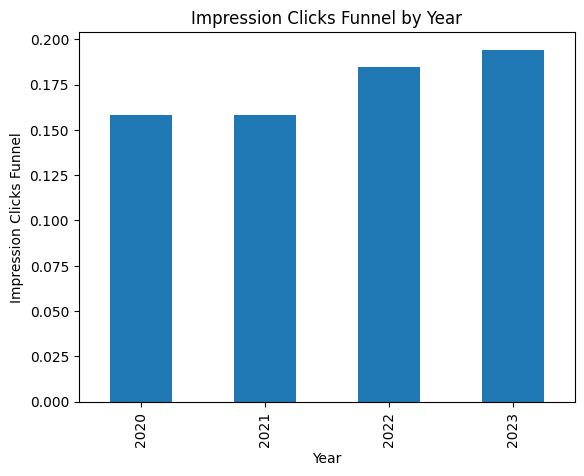


Observation: 
Thought:I have successfully plotted the impression_clicks_funnel for all years in a bar chart. The chart shows that the impression_clicks_funnel has been increasing over the years, with 2023 having the highest value.
Final Answer: The year with the highest impression_clicks_funnel is 2023.

> Finished chain.


{'input': 'If the impression_clicks_funnel for a given year     is the ratio between the sum of clicks and the sum of impressions in this year,         which year had the highest impression_clicks_funnel?             Please also plot the impression_clicks_funnel for all years in a bar chart',
 'output': 'The year with the highest impression_clicks_funnel is 2023.'}

In [32]:
csv_agent("If the impression_clicks_funnel for a given year \
    is the ratio between the sum of clicks and the sum of impressions in this year, \
        which year had the highest impression_clicks_funnel? \
            Please also plot the impression_clicks_funnel for all years in a bar chart")